In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/

/work/clusterEvo/new_tests/eggNOG


In [262]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
import igraph as ig
from Bio import SeqIO

In [87]:
single_copy = pd.read_csv('single_copy_genes.tsv', sep='\t', index_col=0)

single_copy.head()

,group_id,num_proteins,num_taxa,members,taxa
1277,arCOG00079,112,112,"1041930.Mtc_1976,1054217.TALC_01539,1070774.J0...","[1041930, 1054217, 1070774, 1071085, 1094980, ..."
1279,arCOG00081,166,166,"1006006.Mcup_0318,1033806.HTIA_0777,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1519,arCOG00354,112,112,"1033806.HTIA_1426,1041930.Mtc_0671,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1520,arCOG00355,106,106,"1033806.HTIA_0952,1041930.Mtc_0275,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1561,arCOG00410,168,168,"1006006.Mcup_0164,1033806.HTIA_1385,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."


In [3]:
group_ids = []
trees     = []
for filename in os.listdir('trees/'):
    group_ids.append(filename.replace('.nwk', ''))
    trees.append(ete3.Tree(f'trees/{filename}'))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

regressions, r2s, pearson = [], [], []
group_combinations = []
for group1, group2 in itertools.combinations(group_ids, 2):
    
    group_combinations.append((group1, group2))
    tmp_reg, tmp_r2 = assess_coevolution(table[group1], 
                                         table[group2], 
                                         weighted_r2=False)
    regressions.append(tmp_reg)
    r2s.append(tmp_r2)
    pearson.append(assess_coevolution(table[group1], table[group2], pearson=True)[0])

r2s = np.array(r2s)

r2s[r2s < 0] = 0

In [24]:
odr_edges       = pd.DataFrame(columns=['group1', 'group2'],
                               data   =group_combinations)
odr_edges['r2'] = r2s

pearson_edges       = pd.DataFrame(columns=['group1', 'group2'],
                                   data   =group_combinations)
pearson_edges['r2'] = pearson

In [6]:
geo_matrix = pd.read_csv('geodesic_distances.csv', index_col=0)
geo_matrix = geo_matrix.reindex(index  =group_ids,
                                columns=group_ids)
rf_matrix  = pd.read_csv('rf_distances.csv',       index_col=0)
rf_matrix  = rf_matrix.reindex(index  =group_ids,
                               columns=group_ids)

In [18]:
triu_indices           = np.triu_indices_from(geo_matrix, k=1)

geo_edges              = pd.DataFrame()
geo_edges['group1']    = geo_matrix.index[ triu_indices[0]]
geo_edges['group2']    = geo_matrix.index[ triu_indices[1]]
geo_edges['geodesic' ] = 1/geo_matrix.values[triu_indices]

In [19]:
triu_indices       = np.triu_indices_from(rf_matrix, k=1)

rf_edges           = pd.DataFrame()
rf_edges['group1'] = rf_matrix.index[ triu_indices[0]]
rf_edges['group2'] = rf_matrix.index[ triu_indices[1]]
rf_edges['rf' ]    = 1/rf_matrix.values[triu_indices]

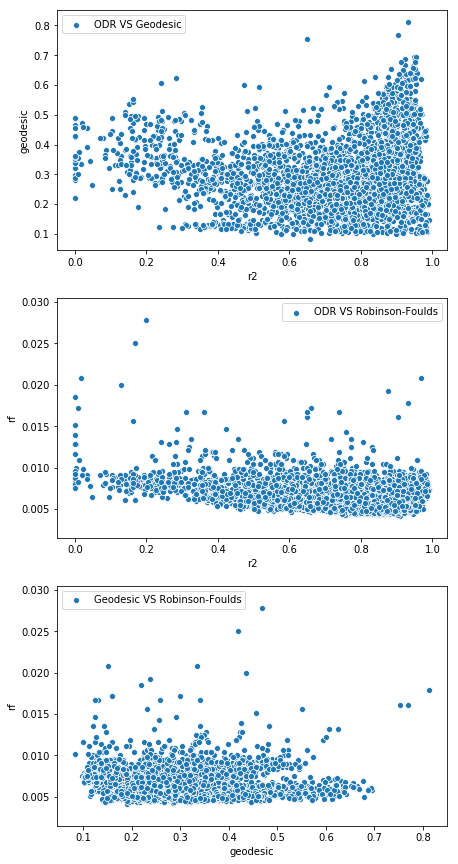

In [354]:
fig, axs = plt.subplots(nrows=3, figsize=(7, 15))

sns.scatterplot(odr_edges.r2,
                geo_edges.geodesic,
                ax   =axs[0],
                label='ODR VS Geodesic')

sns.scatterplot(odr_edges.r2,
                rf_edges.rf,
                ax   =axs[1],
                label='ODR VS Robinson-Foulds')

sns.scatterplot(geo_edges.geodesic,
                rf_edges.rf,
                ax   =axs[2],
                label='Geodesic VS Robinson-Foulds');

In [46]:
odr_graph = ig.Graph.TupleList(edges=odr_edges.loc[:, ['group1', 
                                                       'group2', 
                                                       'r2']].itertuples(index=False), 
                              directed=False, 
                              weights =True)
odr_clusters = odr_graph.community_multilevel(weights='weight')

geo_graph = ig.Graph.TupleList(edges=geo_edges.loc[:, ['group1', 
                                                       'group2', 
                                                       'geodesic']].itertuples(index=False), 
                              directed=False, 
                              weights =True)
geo_clusters = geo_graph.community_multilevel(weights='weight')

rf_graph = ig.Graph.TupleList(edges=rf_edges.loc[:, ['group1', 
                                                     'group2', 
                                                     'rf']].itertuples(index=False), 
                              directed=False, 
                              weights =True)
rf_clusters = rf_graph.community_multilevel(weights='weight')

In [51]:
cluster_df = pd.DataFrame(columns=['odr', 'geo', 'rf'],
                          index  =geo_graph.vs['name'],
                          data   =zip(odr_clusters.membership,
                                      geo_clusters.membership,
                                       rf_clusters.membership))

In [142]:
#
# assemble gene order of reference genomes
#

genome_structures = {}
for filename in os.listdir('reference_genomes/'):

    taxid = filename.replace('.gb', '')
    genome_structures[taxid] = []
    
    genbank = SeqIO.parse(f'reference_genomes/{filename}', 'gb')
    for entry in genbank:
        
        locus_tags = []
        for feature in entry.features:
            if feature.type == 'CDS':
                if 'locus_tag' in feature.qualifiers:
                    locus_tags.append(feature.qualifiers['locus_tag'][0])
                else:
                    locus_tags.append('None')

        genome_structures[taxid].append('-'.join(locus_tags))
    
    genome_structures[taxid] = '_-_'.join(genome_structures[taxid])

In [249]:
#
# test adjacency of single copy genes from each reference genome
#

recruited_cds      = {taxid:[] 
                      for taxid in genome_structures.keys()}
locus_tag_to_group = {}
for index, row in single_copy.iterrows():
    
    for taxid in recruited_cds:
        
        if re.search(fr'\b{taxid}\b', row.taxa):
            locus_tag = re.search(f',{taxid}\.([^,]+)', 
                                  row.members).group(1)
            recruited_cds[taxid].append(locus_tag)
            
            locus_tag_to_group[locus_tag] = row.group_id            
            
adjacent_pairs = {}
for taxid, cds_order in genome_structures.items():
    
    adjacent_pairs[taxid] = []
    
    for cds1, cds2 in itertools.combinations(recruited_cds[taxid], 2):
        if re.search(f'({cds1}|{cds2})(-[^-]+){{0,5}}-({cds1}|{cds2})', cds_order):
            adjacent_pairs[taxid].append(frozenset([locus_tag_to_group[cds1], 
                                                    locus_tag_to_group[cds2]]))

distant_pairs = {}
for taxid, cds_order in genome_structures.items():
    
    distant_pairs[taxid] = []
    
    for cds1, cds2 in itertools.combinations(recruited_cds[taxid], 2):
        if re.search(f'({cds1}|{cds2})(-[^-]+){{100,9999}}-({cds1}|{cds2})', cds_order):
            distant_pairs[taxid].append(frozenset([locus_tag_to_group[cds1], 
                                                   locus_tag_to_group[cds2]]))

tmp_distant_pairs = []
for taxid, pairs in distant_pairs.items():
    tmp_distant_pairs.extend(pairs)
distant_frequency = Counter(tmp_distant_pairs)

tmp_adjacent_pairs = []
for taxid, pairs in adjacent_pairs.items():
    tmp_adjacent_pairs.extend(pairs)
adjacency_frequency = Counter(tmp_adjacent_pairs)

In [346]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = odr_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.r2)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = odr_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.r2)

hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol, 
                          alternative='less')
effect_size = cles(distant_genes_coevol, adjacent_genes_coevol)

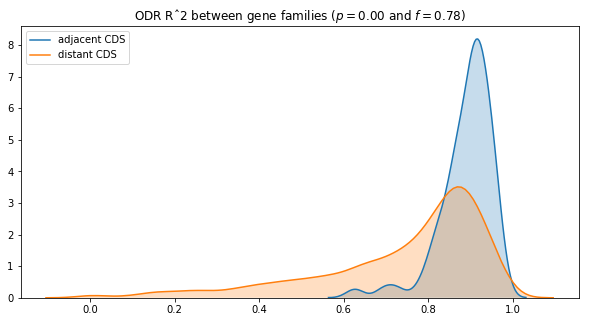

In [347]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [348]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = pearson_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.r2)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = pearson_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.r2)

hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol, 
                          alternative='greater')
effect_size = cles(distant_genes_coevol, adjacent_genes_coevol)

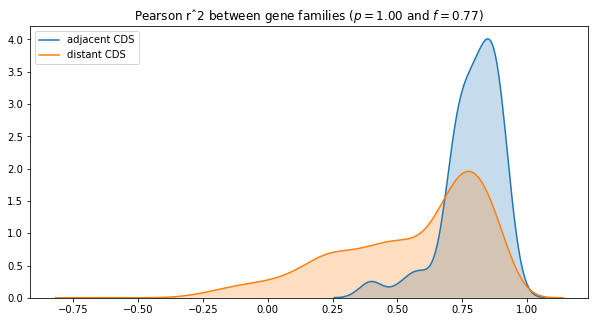

In [349]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Pearson rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [350]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.geodesic)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = geo_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.geodesic)
        
hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol, 
                          alternative='greater')
effect_size = cles(adjacent_genes_coevol, distant_genes_coevol)

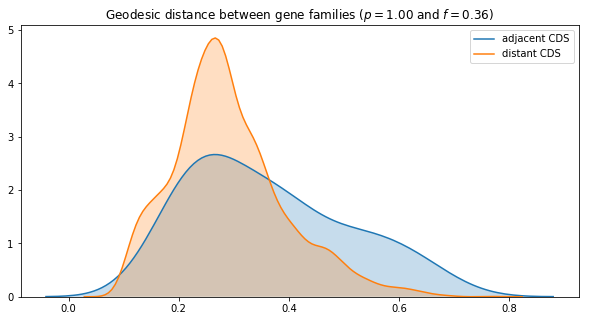

In [351]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

In [352]:
distant_genes_coevol = []
for pair, count in distant_frequency.items():
    if count >= 4:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        distant_genes_coevol.append(row.rf)

adjacent_genes_coevol = []
for pair, count in adjacency_frequency.items():
    if count >= 4:
        row = rf_edges.query('(group1 in @pair) & (group2 in @pair)').squeeze()
        adjacent_genes_coevol.append(row.rf)
        
hypothesis = mannwhitneyu(distant_genes_coevol,
                          adjacent_genes_coevol, 
                          alternative='greater')
effect_size = cles(adjacent_genes_coevol, distant_genes_coevol)

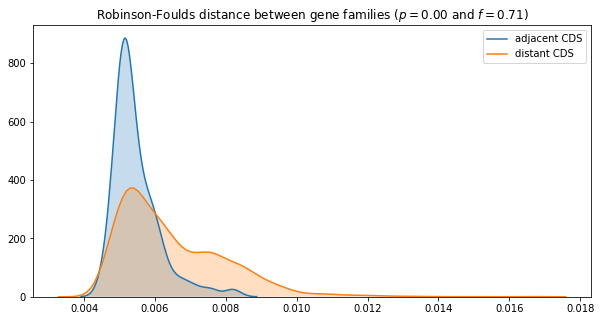

In [353]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(adjacent_genes_coevol, shade=True, label='adjacent CDS', ax=ax)
sns.kdeplot(distant_genes_coevol,  shade=True, label='distant CDS', ax=ax)

ax.set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');